# Przygotowanie

In [1]:
import pandas as pd
import numpy as np
import pickle

import tensorflow
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.utils import plot_model

from sklearn.metrics import classification_report, roc_curve, confusion_matrix, auc
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import plot_confusion_matrix

from nltk.tokenize import TweetTokenizer # needed to import SVM

from utils import tsnescatterplot

from gensim.models import Word2Vec

Using TensorFlow backend.


In [2]:
from const import PREPROCESSED_TEST_PATH, PREPROCESSED_TRAIN_PATH, W2V_MODEL_PATH

In [3]:
df_train = pd.read_pickle(PREPROCESSED_TRAIN_PATH)
df_test = pd.read_pickle(PREPROCESSED_TEST_PATH)

Rekonstrukcja danych wejściowych dla sieci neuronowej

In [4]:
Y_train_NEURAL = df_train.target.to_numpy().reshape(-1,1)
Y_test_NEURAL = df_test.target.to_numpy().reshape(-1,1)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

X_train_NEURAL = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen = 50)
X_test_NEURAL = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen = 50)

Rekonstrukcja danych wejściowych dla SVMa

In [5]:
Y_train_SVM = df_train.target.to_numpy()
Y_test_SVM = df_test.target.to_numpy()

X_train_SVM = df_train.text.to_numpy()
X_test_SVM = df_test.text.to_numpy()

In [6]:
models_NEURAL = [
    "LSTM_V1",
    "LSTM_V2",
    "LSTM_V3"
]

models_SVM = [
    "SVM"
]

Potrzebujemy zadeklarować funkcję __tokenize__ i __CountVectorizer__ aby odtworzyć mode SVM oraz do dokładniejszej analizy wyników tego modelu. 

In [7]:
def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

# Funkcje pomocnicze

In [8]:
def get_roc_curve_svm(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    auc_rf = auc(fpr, tpr)
    return fpr, tpr, auc_rf

def get_roc_curve_ann(model, X, y):
    pred_proba = model.predict_proba(X).ravel()
    fpr, tpr, _ = roc_curve(y.ravel(), pred_proba)
    auc_rf = auc(fpr, tpr)
    return fpr, tpr, auc_rf

def draw_roc(roc):
    fpr, tpr, auc_rf = roc
    plt.figure()
    plt.plot(fpr, tpr, color="red", label='ROC (area = {:.3f})'.format(auc_rf))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curve')
    plt.show()
    
def draw_confusion_matrix(matrix):
    class_names = ['negatywna', 'pozytywna']
    plot_confusion_matrix(conf_mat=matrix,
                          show_absolute=True,
                          show_normed=True,
                          colorbar=True,
                          class_names=class_names)

    plt.show()
    
def draw_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'test'], loc='upper right')
    
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'test'], loc='upper right')
    
    plt.show()
    
    plt.plot(history['lr'])
    plt.ylabel('Learning rate')
    plt.xlabel('Epoch')
    
    plt.show()

# Zbieranie wyników

In [9]:
scores = []
roc = []

320000/320000 [==============================] - 17s 52us/step

Model: "LSTM_V1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           73362000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 73,522,501
Trainable params: 160,501
Non-trainable params: 73,362,000
_________________________________________________________________


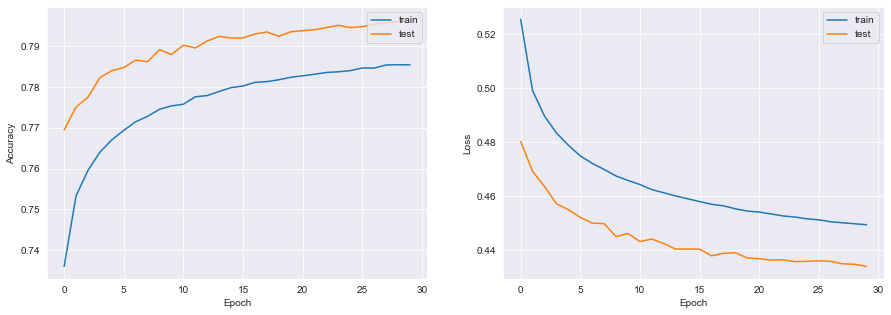

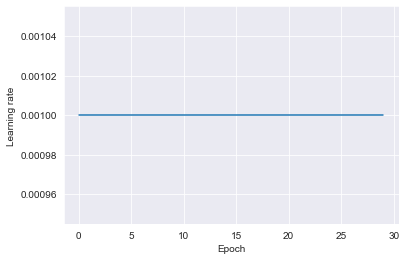

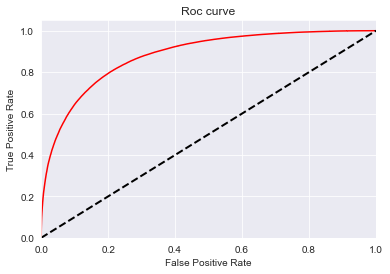

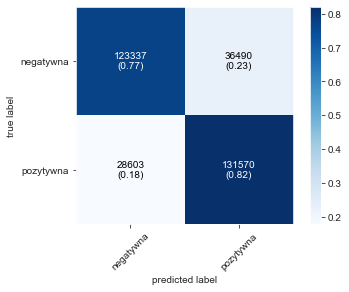

320000/320000 [==============================] - 19s 58us/step

Model: "LSTM_V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           73362000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            96064     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_____________________________________________________________

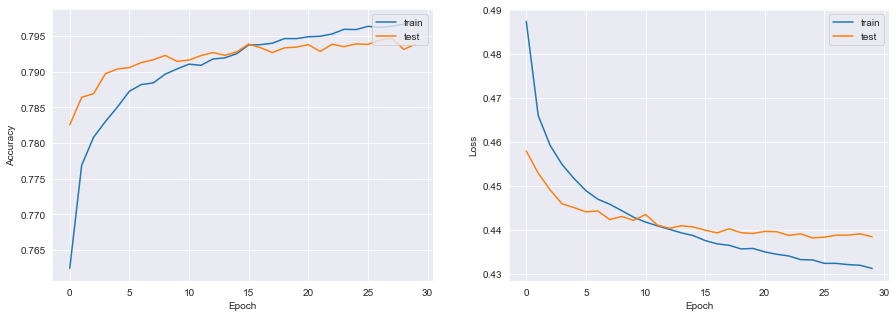

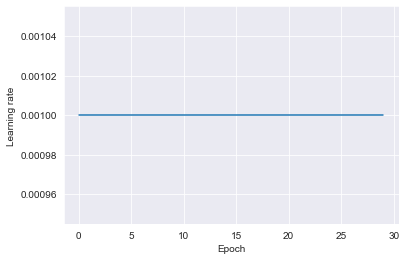

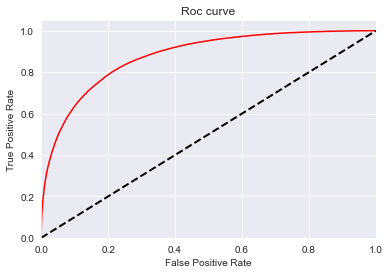

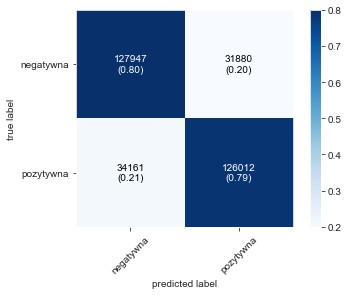

C:\Users\LukMcCall\anaconda3\envs\sentimental140\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


320000/320000 [==============================] - 5s 17us/step

Model: "LSTM_V3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 32)            7825280   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 7,841,931
Trainable params: 7,841,931
Non-trainable params: 0
_________________________________________________________________


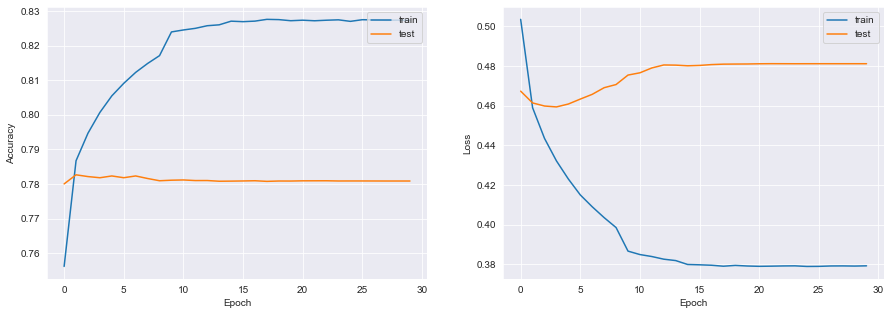

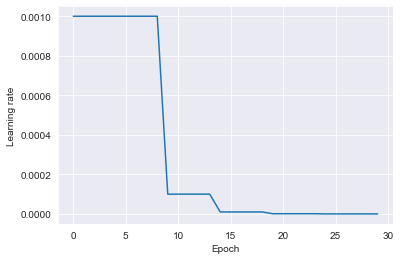

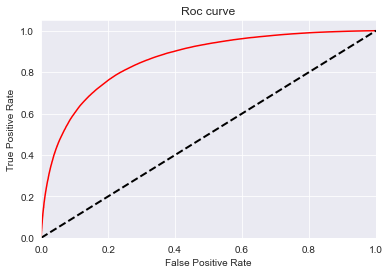

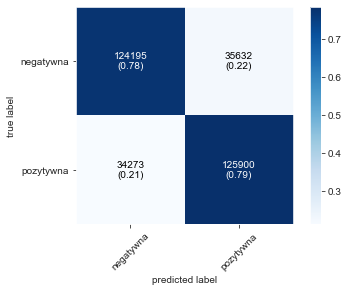

In [10]:
for model_name in models_NEURAL:
    X = X_test_NEURAL
    Y = Y_test_NEURAL
    
    model = load_model("{}.model".format(model_name))
    score = model.evaluate(X, Y, batch_size=1024)
    scores.append([model_name, score[1], score[0]])
    
    predictions = model.predict_classes(X) 

    print()
    print("="*70)
    model.summary()
    
    history = np.load("{}_history.npy".format(model_name), allow_pickle = True).item()
    draw_history(history)
    
    roc_ann = get_roc_curve_ann(model, X, Y)
    roc.append({"name": model_name, "plot": roc_ann})
    draw_roc(roc_ann)
    
    cnf_matrix = confusion_matrix(Y, predictions)
    draw_confusion_matrix(cnf_matrix)



SVM

              precision    recall  f1-score   support

           0       0.73      0.71      0.72    159827
           1       0.72      0.74      0.73    160173

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000



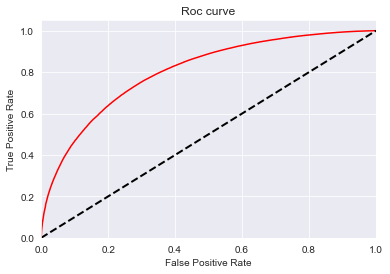

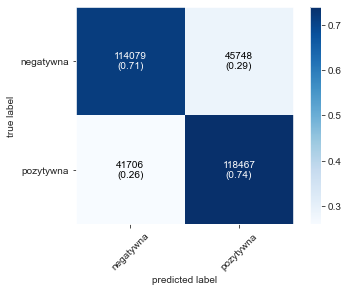

In [11]:
for model_name in models_SVM:
    with open("{}.model".format(model_name), 'rb') as pickle_model:
        model = pickle.load(pickle_model)
        predictions = model.predict(X_test_SVM)
        
        print()
        print(model_name)
        print()
        print("="*70)
        print(classification_report(Y_test_SVM, predictions))
        
        roc_svm = get_roc_curve_svm(model, X_test_SVM, Y_test_SVM)
        roc.append({"name": model_name, "plot": roc_svm})
        draw_roc(roc_svm)

        cnf_matrix = confusion_matrix(Y_test_SVM, predictions)
        draw_confusion_matrix(cnf_matrix)


In [12]:
df = pd.DataFrame(scores, columns=["Model", "Accuracy", "Loss"])
df

,Model,Accuracy,Loss
0,LSTM_V1,0.796584,0.433847
1,LSTM_V2,0.793622,0.438481
2,LSTM_V3,0.781547,0.481316


# ROC

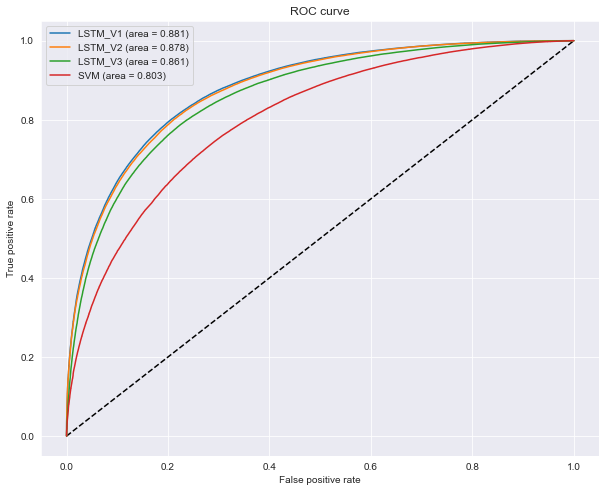

In [28]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
for r in roc:
    fpr, tpr, auc_rf = r["plot"]
    plt.plot(fpr, tpr, label='{} (area = {:.3f})'.format(r["name"], auc_rf))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# w2v
Duży wpływ na skuteczność sieci neuronowych w moim module ma algorytm zamieniający słowa na wektory. Dlatego też przygotowałem dokładniejszą wizualizację tego jak działa.

In [6]:
w2v_model = Word2Vec.load(W2V_MODEL_PATH)

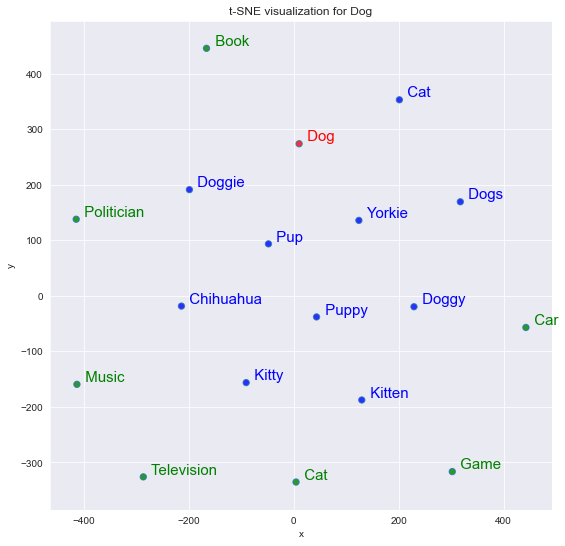

In [12]:
tsnescatterplot(w2v_model, 'dog', ['cat', 'car', 'book', 'music', 'television', 'game', 'politician'], 10)

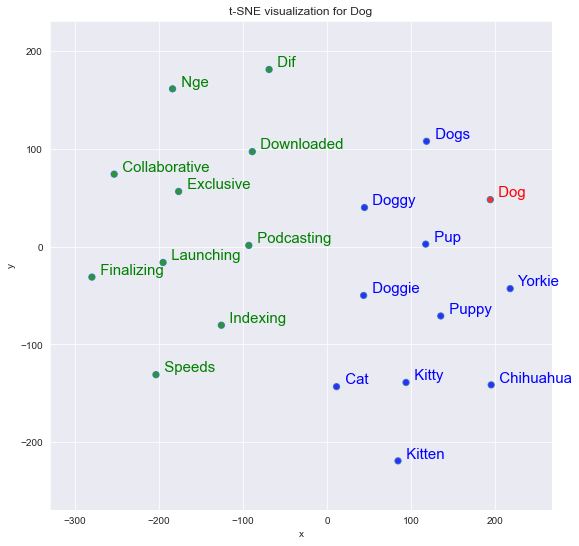

In [17]:
tsnescatterplot(w2v_model, 'dog', [i[0] for i in w2v_model.wv.most_similar(negative=["dog"])], 10)

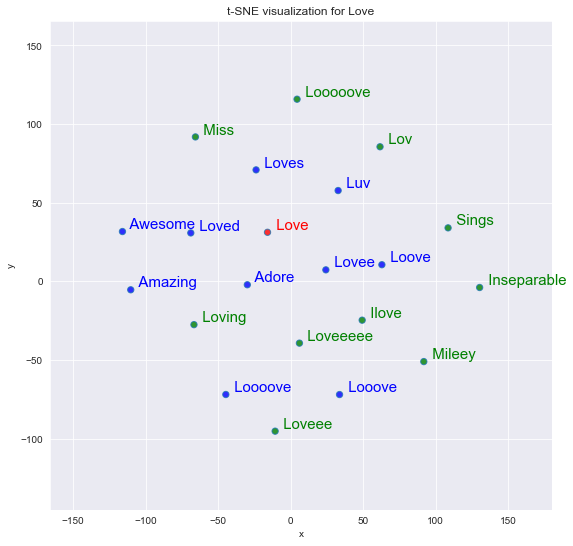

In [19]:
tsnescatterplot(w2v_model, "love", [t[0] for t in w2v_model.wv.most_similar(positive=["love"], topn=20)][10:], 10)